In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [11]:
def read_vcf(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()


    for i, line in enumerate(lines):
        if line.startswith('#CHROM'):
            header = line.strip().lstrip('#').split('\t') 
            data_start = i + 1
            break


    df = pd.read_csv(file_path, sep='\t', skiprows=data_start, names=header)

    df.rename(columns={'CHROM': '#CHROM'}, inplace=True)

    format_cols = df['FORMAT'].iloc[0].split(':')
    gwas_data = df['ieu-b-4877'].str.split(':', expand=True)
    gwas_data.columns = format_cols

    for col in ['ES', 'SE', 'LP', 'AF']:
        df[col] = pd.to_numeric(gwas_data[col], errors='coerce')

    return df[['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'ES', 'SE', 'LP', 'AF']]

vcf_file = "ieu-b-4877.vcf"
df = read_vcf(vcf_file)
print(df.head())
print(df)


df_filtered = df[df['AF'] >= 0.01].copy()

df_filtered['P'] = 10 ** (-df_filtered['LP'])




   #CHROM     POS            ID REF ALT        ES        SE        LP       AF
0       1   79137   rs143777184   A   T -0.040444  0.046091  0.420216  0.00220
1       1   86028   rs114608975   T   C  0.001702  0.006868  0.094744  0.09160
2       1  526736    rs28863004   C   G -0.016806  0.019317  0.415669  0.00945
3       1  533198  rs1557498752   C   T  0.020398  0.029442  0.311580  0.00405
4       1  544584   rs576404767   C   T  0.053913  0.044467  0.645892  0.00228
          #CHROM       POS            ID REF ALT        ES        SE  \
0              1     79137   rs143777184   A   T -0.040444  0.046091   
1              1     86028   rs114608975   T   C  0.001702  0.006868   
2              1    526736    rs28863004   C   G -0.016806  0.019317   
3              1    533198  rs1557498752   C   T  0.020398  0.029442   
4              1    544584   rs576404767   C   T  0.053913  0.044467   
...          ...       ...           ...  ..  ..       ...       ...   
11802360      22  5123

/var/folders/m5/0wg4jmc16qnb_0pxpgzhd_w80000gn/T/ipykernel_36367/3174288067.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


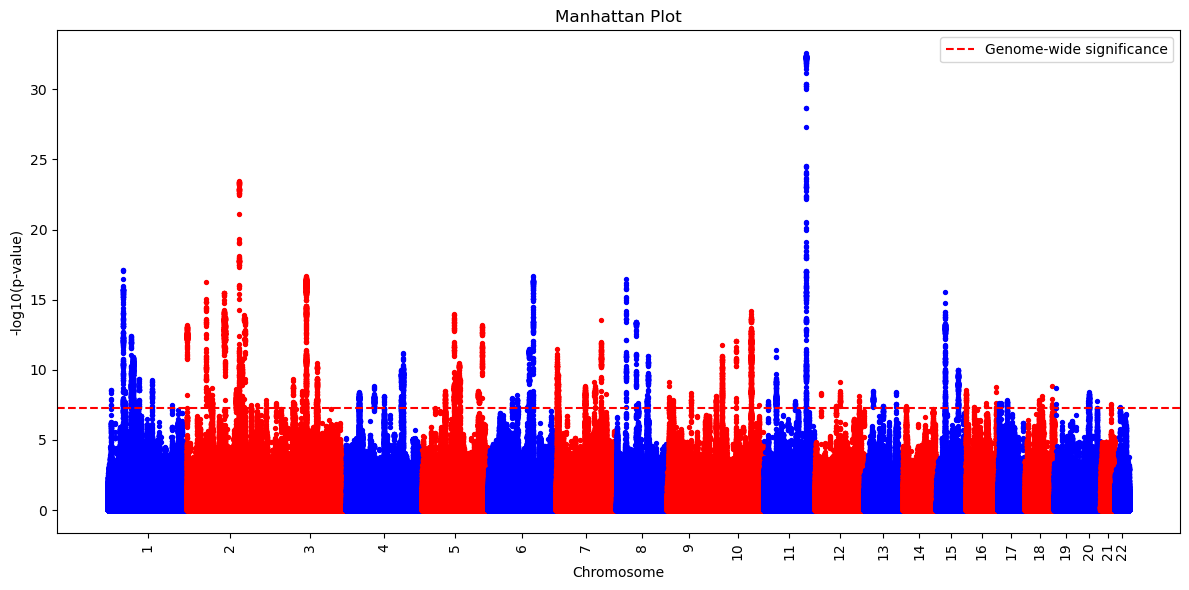

In [ ]:
def manhattan_plot(df, title="Manhattan Plot"):
    df['-log10(P)'] = -np.log10(df['P'])
    df['CHR'] = df['#CHROM'].astype(str)
    df['ind'] = range(len(df))
    df_grouped = df.groupby('CHR')

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue', 'red']
    x_labels = []
    x_labels_pos = []

    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='-log10(P)', color=colors[num % 2], ax=ax, s=8)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)

    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, rotation=90)
    ax.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

manhattan_plot(df_filtered)


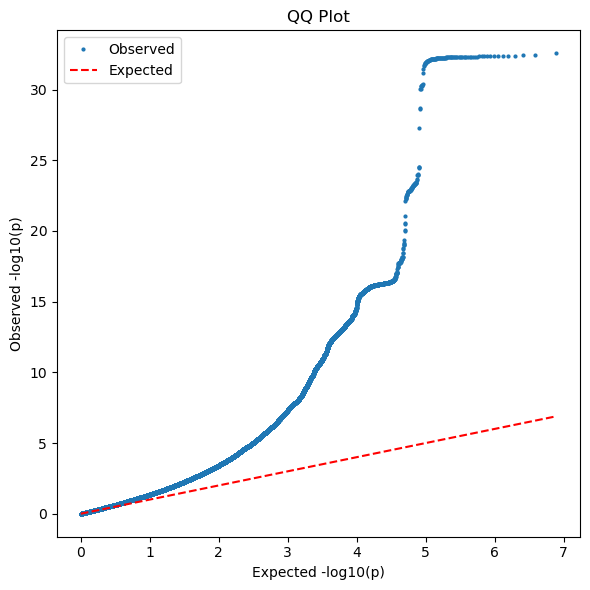

In [ ]:
def qq_plot(pvals):
    pvals = pvals[np.isfinite(pvals)]
    expected = -np.log10(np.linspace(1/len(pvals), 1, len(pvals)))
    observed = -np.log10(np.sort(pvals))

    plt.figure(figsize=(6, 6))
    plt.plot(expected, observed, 'o', markersize=2, label='Observed')
    plt.plot([0, max(expected)], [0, max(expected)], 'r--', label='Expected')
    plt.xlabel('Expected -log10(p)')
    plt.ylabel('Observed -log10(p)')
    plt.title('QQ Plot')
    plt.legend()
    plt.tight_layout()
    plt.show()

qq_plot(df_filtered['P'].values)

/var/folders/m5/0wg4jmc16qnb_0pxpgzhd_w80000gn/T/ipykernel_36367/1506601893.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


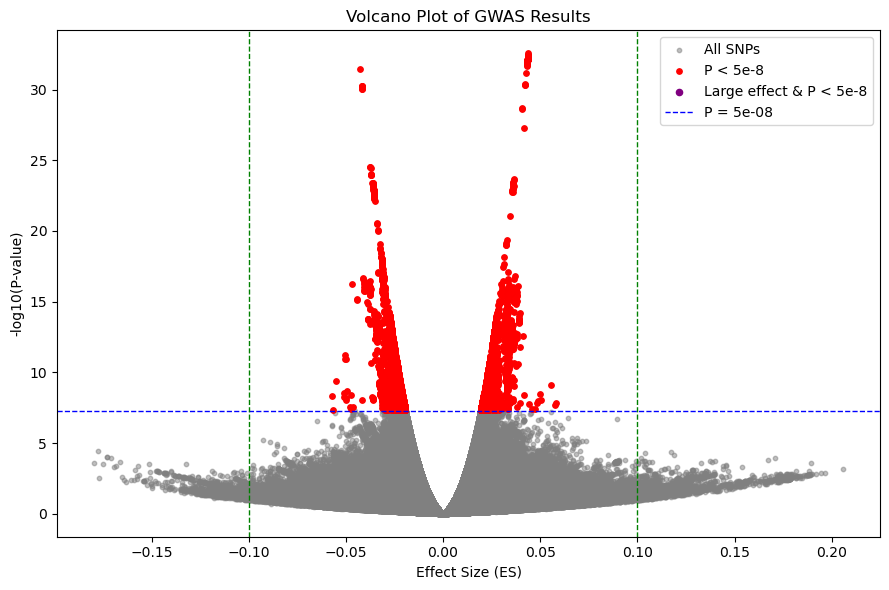

In [ ]:
def volcano_plot(df, p_threshold=5e-8, effect_threshold=0.1):
    df = df.copy()
    df['-log10(P)'] = -np.log10(df['P'])

    plt.figure(figsize=(9, 6))


    plt.scatter(df['ES'], df['-log10(P)'], color='gray', alpha=0.5, s=10, label='All SNPs')

    sig_only = df[df['P'] < p_threshold]
    plt.scatter(sig_only['ES'], sig_only['-log10(P)'], color='red', s=15, label='P < 5e-8')

    large_effect = sig_only[sig_only['ES'].abs() > effect_threshold]
    plt.scatter(large_effect['ES'], large_effect['-log10(P)'], color='purple', s=20, label='Large effect & P < 5e-8')

    plt.axhline(-np.log10(p_threshold), color='blue', linestyle='--', linewidth=1, label=f'P = {p_threshold}')
    plt.axvline(-effect_threshold, color='green', linestyle='--', linewidth=1)
    plt.axvline(effect_threshold, color='green', linestyle='--', linewidth=1)

    plt.xlabel('Effect Size (ES)')
    plt.ylabel('-log10(P-value)')
    plt.title('Volcano Plot of GWAS Results')
    plt.legend()
    plt.tight_layout()
    plt.show()


volcano_plot(df_filtered)

In [ ]:
genome_sig = df_filtered[df_filtered['P'] < 5e-8].dropna(subset=['P', 'ID', 'POS'])


gwas_for_clumping = genome_sig.loc[:, ['ID', '#CHROM', 'POS', 'P']].rename(
    columns={
        'ID': 'SNP',
        '#CHROM': 'CHR',
        'POS': 'BP'
    }
)

gwas_for_clumping['CHR'] = gwas_for_clumping['CHR'].astype(int)

gwas_for_clumping.to_csv("gwas_for_clumping.txt", sep='\t', index=False)

genome_sig[['#CHROM', 'POS', 'ID', 'REF', 'ALT']].to_csv("top_snps_for_annotation.tsv", sep='\t', index=False)

print(f"{genome_sig.shape[0]} significant SNPs found.")


7846 significant SNPs found.


The file "top_snps_for_annotation.tsv" is uploaded to Ensembl VEP to determine the effects of the SNPs. A VCF format file is generated. 